In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd

# eBay API credentials
api_endpoint = 'https://api.ebay.com/ws/api.dll'
app_id = 'YOUR_APP_ID'
dev_id = 'YOUR_DEV_ID'
cert_id = 'YOUR_CERT_ID'
auth_token = 'YOUR_AUTH_TOKEN'

# Define API headers
headers = {
    'X-EBAY-API-CALL-NAME': 'GetSellerTransactions',
    'X-EBAY-API-COMPATIBILITY-LEVEL': '1085',
    'X-EBAY-API-DEV-NAME': dev_id,
    'X-EBAY-API-APP-NAME': app_id,
    'X-EBAY-API-CERT-NAME': cert_id,
    'X-EBAY-API-SITEID': '0',
    'Content-Type': 'text/xml'
}

# Define API request payload
payload = f'''
<?xml version="1.0" encoding="utf-8"?>
<GetSellerTransactionsRequest xmlns="urn:ebay:apis:eBLBaseComponents">
  <RequesterCredentials>
    <eBayAuthToken>{auth_token}</eBayAuthToken>
  </RequesterCredentials>
  <ModTimeFrom>2022-01-01T00:00:00.000Z</ModTimeFrom>
  <ModTimeTo>2022-12-31T23:59:59.999Z</ModTimeTo>
</GetSellerTransactionsRequest>
'''

# Make the API request
response = requests.post(api_endpoint, data=payload, headers=headers)
root = ET.fromstring(response.text)

# Parse the XML response and extract sales and product information
sales_data = []
for transaction in root.findall('.//Transaction'):
    transaction_id = transaction.find('TransactionID').text
    sale_price = float(transaction.find('TransactionPrice/Value').text)
    item = transaction.find('Item')
    title = item.find('Title').text
    sku = item.find('SKU').text
    
    sales_data.append({
        'TransactionID': transaction_id,
        'SalePrice': sale_price,
        'Title': title,
        'SKU': sku
    })

# Create DataFrame from the sales data
df = pd.DataFrame(sales_data)

# Display the DataFrame
print(df)

In [5]:
# Path to the CSV file
csv_file = r'C:\Users\Samuel Coromandel\Ebay Store Sales Dashboard\Ebay Store\eBay-ListingsSalesReport.csv'

# Read the CSV file with the first row as column headers
salesreport_df = pd.read_csv(csv_file, header=0)

# Set display options to show all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Print the DataFrame with the updated column headers
print(salesreport_df)

                                        Listing title  eBay item ID Store category L1 Store category L2  Quantity sold Total sales (Includes taxes) Item sales Taxes and government fees paid by buyer to you Taxes and government fees paid by buyer to eBay Shipping and handling paid by buyer to you Total selling costs Insertion fees Optional listing upgrade fees Final value fees Ads Standard fees Ads Advanced fees Ads Express fees International fees Other eBay fees Deposit processing fees Fee credits Shipping labels cost (Amount you paid to buy shipping labels on eBay) Net sales (Net of taxes and selling costs) Average Selling price  Quantity sold via promoted listing  Quantity sold via Best Offers  Quantity sold via Seller Initiated Offers
0   DenTek Triple Clean Advanced Clean Floss Picks...  3.945600e+11                 -                 -              8                      $42.09     $39.92                                          $0.00                                           $2.17

In [27]:
purchasehistory_df = pd.read_csv(r'C:\Users\Samuel Coromandel\Ebay Store Sales Dashboard\Ebay Store\Purchase History.csv')

print(purchasehistory_df)

       OrderNumber  OrderDate        ItemID                  Seller                                           ItemName  ItemPrice Currency  OrderTotal  OrderNotes      TrackingNumber                                  View Order Detail
0   10-10130-39265   2-Jun-23  3.741340e+11             marswa-1711  La Vie Est Belle Perfume by Lancome 2.5 fl oz ...      42.09      USD   US $45.35         NaN                 NaN  https://www.ebay.com/fdbk/leave_single_feedbac...
1   09-10127-11432   1-Jun-23  2.556050e+11           puritan_pride  Puritan's Pride Neuro-PS (Phosphatidylserine) ...      20.28      USD   US $19.26         NaN                 NaN  https://www.ebay.com/fdbk/leave_single_feedbac...
2   01-10114-52655  28-May-23  4.027640e+11           kaya-naturals  Natural Testosterone Booster - Increase Energy...      11.48      USD   US $11.59         NaN         9.40011E+21  https://www.ebay.com/ship/trk/tracking-details...
3   04-10103-43872  25-May-23  4.011320e+11              forever

In [28]:
#sql logic: salesreport_df as sr join purchasehistory_df as ph on sr.'Listing title' = ph.'ItemName'

# Problem: Ideally perform the join on 'Listing title' and 'ItemName' columns, however, some title & names don't match
# Solution 1: spend time writing a complex script to match vaguely matching strings
# Solution 2: use my custom ebay app to get the matching dictionary key-value pairs for item numbers (time consuming)
# Solution 3: Don't use the conjoined data to analyze metrics. create a new column based on custom formula for the metrics needed 

# Joining the data for reference but it's not usable in the current state.  
# logic: pd.concat([df1,df2], axis=1)
join_df = pd.concat([salesreport_df, purchasehistory_df], axis=1)


print(join_df)

                                        Listing title  eBay item ID Store category L1 Store category L2  Quantity sold Total sales (Includes taxes) Item sales Taxes and government fees paid by buyer to you Taxes and government fees paid by buyer to eBay Shipping and handling paid by buyer to you Total selling costs Insertion fees Optional listing upgrade fees Final value fees Ads Standard fees Ads Advanced fees Ads Express fees International fees Other eBay fees Deposit processing fees Fee credits Shipping labels cost (Amount you paid to buy shipping labels on eBay) Net sales (Net of taxes and selling costs) Average Selling price  Quantity sold via promoted listing  Quantity sold via Best Offers  Quantity sold via Seller Initiated Offers     OrderNumber  OrderDate        ItemID                  Seller                                           ItemName  ItemPrice Currency  OrderTotal  OrderNotes      TrackingNumber                                  View Order Detail
0   DenTek Triple Cle

## Exploratory Data Analysis

In [29]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" QUANTILES ".center(70,'-'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_data(join_df)

------------------------------- SHAPE --------------------------------
Rows: 47
Columns: 38
------------------------------- TYPES --------------------------------
Listing title                                                             object
eBay item ID                                                             float64
Store category L1                                                         object
Store category L2                                                         object
Quantity sold                                                            float64
Total sales (Includes taxes)                                              object
Item sales                                                                object
Taxes and government fees paid by buyer to you                            object
Taxes and government fees paid by buyer to eBay                           object
Shipping and handling paid by buyer to you                                object
Total selling costs        

In [30]:
#Clean up the Item sales column using pandas string methods
join_df['Item sales'] = join_df['Item sales'].str.replace('$', '').str.strip().astype(float)


print(join_df['Item sales'].dtype)


float64


C:\Users\Samuel Coromandel\AppData\Local\Temp\ipykernel_8268\306513509.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  join_df['Item sales'] = join_df['Item sales'].str.replace('$', '').str.strip().astype(float)


Descriptive Statistics

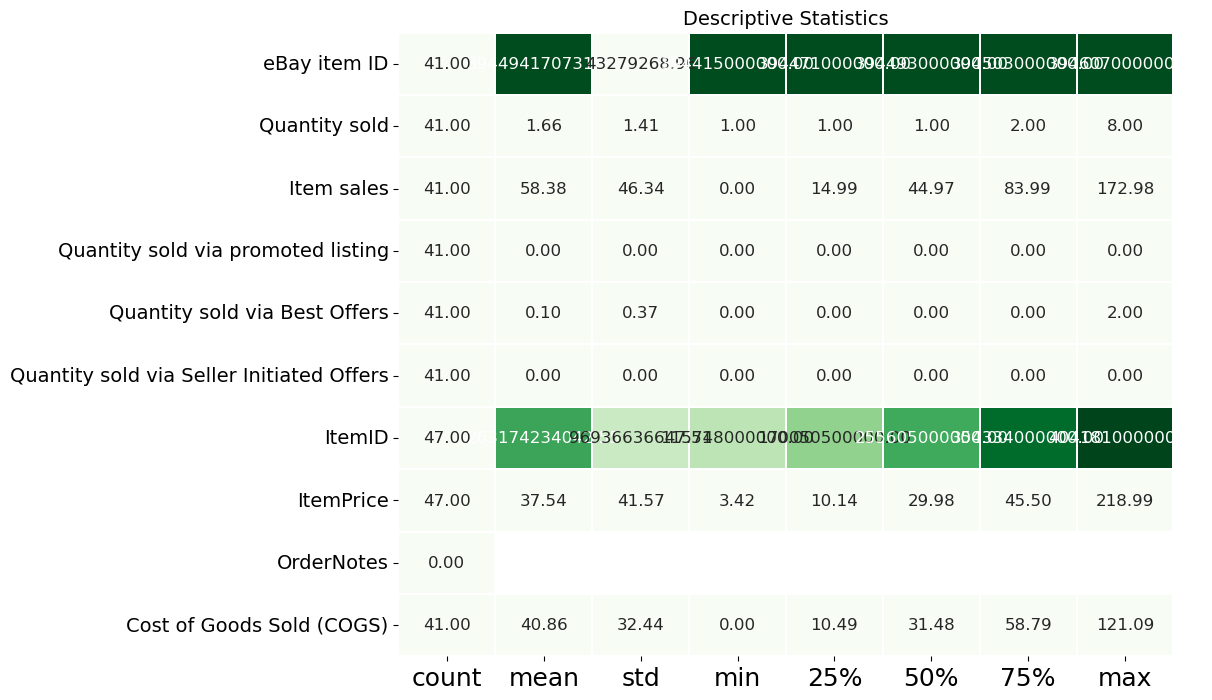

In [33]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(join_df.select_dtypes(include = [float, int]))

In [32]:
#import numpy as np

#join_df['Cost of Goods Sold (COGS)'] = np.where(join_df['OrderTotal'].isnull(), 
                                      #join_df['Item sales'] - (join_df['Item sales'] * 0.52), 
                                      #join_df['OrderTotal'].str[4:])

#Problem: There are missing values for the OrderTotal column which is needed to compute COGS 
#Solution: using a custom formula to compute COGS with great accuracy:  
join_df['Cost of Goods Sold (COGS)'] = join_df['Item sales'] - (join_df['Item sales'] * 0.3)


In [ ]:
print(join_df)

In [ ]:
join_df.to_csv('Joined_Ebay_Store_Data')

#### Scratch work (converting DAX logic into python and vice-versa): 
NetSales_clean = IF(ISBLANK(Joined_Ebay_Store_Data[Net sales (Net of taxes and selling costs)]), Joined_Ebay_Store_Data[ItemPrice]*1.2, Joined_Ebay_Store_Data[Net sales (Net of taxes and selling costs)])
Month = Joined_Ebay_Store_Data[OrderDate]
